In [1]:
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb


In [2]:
def calculate_age(born, year):
    """year年4月1日時点での年齢を返す"""
    date = datetime(year,4,1)
    return date.year - born.year - ((date.month, date.day) < (born.month, born.day))

def is_same_team(df, col):
    return (df["team"] in df[col])*1

In [3]:
# データ読み込み
train_2018_df = pd.read_csv('/Users/onehe/Desktop/プログラミング/コンペティション/Jリーグ選手出場時間予測_nishika/data/input/train_2018.csv')
train_2017_df = pd.read_csv('/Users/onehe/Desktop/プログラミング/コンペティション/Jリーグ選手出場時間予測_nishika/data/input/train_2017.csv')
train_2016_df = pd.read_csv('/Users/onehe/Desktop/プログラミング/コンペティション/Jリーグ選手出場時間予測_nishika/data/input/train_2016.csv')

train_2018_df['year'] = 2018
train_2017_df['year'] = 2017
train_2016_df['year'] = 2016

test_df = pd.read_csv("/Users/onehe/Desktop/プログラミング/コンペティション/Jリーグ選手出場時間予測_nishika/data/input/test.csv")
test_df["year"] = 2019

t_df_dic = {2018: test_df, 2017: train_2018_df, 2016: train_2017_df, 2015: train_2016_df}

for year in [2018,2017,2016,2015]:
    t_df = t_df_dic[year]
    t_df["name-team"] = t_df["name"] + "-" + t_df["prev1_team"].apply(lambda x: x.split("・")[-1])
    
    eve_pla_df = pd.read_csv(f"/Users/onehe/Desktop/プログラミング/コンペティション/Jリーグ選手出場時間予測_nishika/data/output/pretime_{year}_記号カウント.csv")
    
    for df in [eve_pla_df]:
        t_df = pd.merge(t_df, df, on="name-team", how="left")
        
    t_df.drop(["name-team"], axis=1, inplace=True)
    t_df_dic[year] = t_df
    
test_df = t_df_dic[2018]
train_2018_df = t_df_dic[2017]
train_2017_df = t_df_dic[2016]
train_2016_df = t_df_dic[2015] 

In [4]:
pd.set_option("display.max_columns", 100)
test_df.head(3)

,id,team,No,name,position,birthdate,height,weight,salary,nth_year,is_youth,nationality,j1_total_num_played,j1_total_scores,j2_total_num_played,j2_total_scores,j3_total_num_played,j3_total_scores,na_total_num_played,na_total_scores,prev3_team,prev2_team,prev1_team,prev3_div,prev2_div,prev1_div,prev3_num_played,prev2_num_played,prev1_num_played,prev3_scores,prev2_scores,prev1_scores,prev3_time_played,prev2_time_played,prev1_time_played,year,total_○,1st_○,2st_○,3st_○,4st_○,total_▲,1st_▲,2st_▲,3st_▲,4st_▲,total_▽,1st_▽,2st_▽,3st_▽,4st_▽,total_◆,1st_◆,2st_◆,3st_◆,4st_◆,total_B,1st_B,2st_B,3st_B,4st_B,total_×,1st_×,2st_×,3st_×,4st_×,total_-,1st_-,2st_-,3st_-,4st_-,time_rate,1st_time_rate,2st_time_rate,3st_time_rate,4st_time_rate
0,0,C大阪,1.0,圍 謙太朗,GK,1991-04-23,190.0,90.0,750,2.0,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,FC東京,C大阪,福岡,1,1,2,0,0,26,0,0,0,0,0,2340,2019,0.619048,0.100,1.000,0.900,0.5,0.000000,0.000,0.0,0.0,0.0,0.000000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.800,0.000,0.000,0.5,0.0,0.0,0.0,0.0,0.0,0.047619,0.1,0.00,0.100,0.0,5.637060,0.915471,9.090909,8.181818,4.545455
1,1,C大阪,2.0,松田 陸,DF,1991-07-24,171.0,69.0,2700,4.0,NaN,NaN,76.0,3.0,42.0,2.0,NaN,NaN,NaN,NaN,C大阪,C大阪,C大阪,2,1,1,42,31,29,2,2,0,3733,2662,2524,2019,0.735294,0.875,0.875,0.750,0.5,0.000000,0.000,0.0,0.0,0.0,0.117647,0.000,0.125,0.125,0.2,0.0,0.0,0.0,0.0,0.0,0.058824,0.125,0.000,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.088235,0.0,0.00,0.000,0.3,7.498515,7.954545,9.078283,7.853535,5.585859
2,2,C大阪,3.0,木本 恭生,DF,1993-08-06,183.0,73.0,2000,4.0,NaN,NaN,45.0,2.0,1.0,1.0,23.0,1.0,NaN,NaN,C大阪,C大阪,C大阪,2,1,1,1,23,22,1,2,0,25,1296,1651,2019,0.294118,0.375,0.000,0.625,0.2,0.088235,0.125,0.0,0.0,0.2,0.264706,0.375,0.125,0.250,0.3,0.0,0.0,0.0,0.0,0.0,0.117647,0.125,0.125,0.000,0.2,0.0,0.0,0.0,0.0,0.0,0.235294,0.0,0.75,0.125,0.1,4.904932,6.502525,1.123737,7.878788,4.272727


In [5]:
# チームIDをチーム名に変換する辞書作成
team_df = pd.read_csv('/Users/onehe/Desktop/プログラミング/コンペティション/Jリーグ選手出場時間予測_nishika/data/input/team.csv')
team_dic = dict(zip(team_df['team_id'], team_df['team_name']))
team_id_list = [v for v in team_dic.values()]
team_id_list_swap = [k for k in team_dic.keys()]

#欠損値補完・特徴量生成
test_df["time_played"] = 0
for df, year in [[test_df, 2019], [train_2018_df, 2018], [train_2017_df, 2017], [train_2016_df, 2016]]:
    df["birthdate"] = pd.to_datetime(df["birthdate"])
    df["age"] = df["birthdate"].apply(lambda x: calculate_age(x, year=year))
    df.drop("birthdate", axis=1, inplace=True)
    
    # 年俸が不明な場合中央値で補完
    med_salary = df[df["salary"] != "-"]["salary"].median(skipna=True)
    df["salary"] = df["salary"].mask(df["salary"] == "-", med_salary)
    df["salary"] = df["salary"].map(int)
    
    #チームIDを一時的に追加
    df["team_id"] = df["team"]
    df["team_id"] = df["team_id"].replace(team_dic)
    
    #年俸をチーム毎に標準化
    df["salary_std"] = df["salary"].copy()
    for i in team_id_list:
        s = df.loc[df["team_id"] == i, "salary"].sum()
        df.loc[df["team_id"] == i, 'salary_std'] /= s
        df.loc[df["team_id"] == i, 'salary_std'] *=100
    df["salary_std"] = df["salary_std"].map(float)
    df.drop("salary",axis=1, inplace=True)
    
       
train_df = pd.concat([train_2018_df, train_2017_df, train_2016_df], axis=0).reset_index(drop=True)
train_df.drop(["team_id"], axis=1, inplace=True)
test_df.drop(["team_id"], axis=1, inplace=True)
test_df.drop(["time_played"], axis=1, inplace=True)

for df in [train_df, test_df]:
    df["is_j1_play"] = ~df["j1_total_num_played"].isnull()*1
    df['is_j2_play'] = ~df['j2_total_num_played'].isnull()*1
    df['is_j3_play'] = ~df['j3_total_num_played'].isnull()*1
    df['is_na_play'] = ~df['na_total_num_played'].isnull()*1
    
    df["is_prev3_same_team"] = df.apply(is_same_team, col="prev3_team", axis=1)
    df['is_prev2_same_team'] = df.apply(is_same_team, col='prev2_team', axis=1)
    df['is_prev1_same_team'] = df.apply(is_same_team, col='prev1_team', axis=1)
    
    for colname in ["is_youth", "j1_total_num_played", "j1_total_scores", "j2_total_num_played", "j2_total_scores", "j3_total_num_played", "j3_total_scores", "na_total_num_played", "na_total_scores"]:
        df[colname] = df[colname].fillna(0)
        
    for colname in ["nationality"]:
        df[colname] = df[colname].fillna("japan")
        
    for colname in ['prev3_div', 'prev2_div', 'prev1_div', 
                    'prev3_num_played', 'prev2_num_played', 'prev1_num_played', 
                    'prev3_scores', 'prev2_scores', 'prev1_scores', 
                    'prev3_time_played', 'prev2_time_played', 'prev1_time_played']:
        df[colname] = df[colname].replace('-',0)
        df[colname] = df[colname].fillna(0)
        df[colname] = df[colname].map(int)
        
    #j2での出場時間はj1時間に変換
    df["new_prev1_time_played"] = df["prev1_time_played"].where(df["prev1_div"] != 2, df["prev1_time_played"]*(34*90)/(42*90))
    df["new_prev2_time_played"] = df["prev2_time_played"].where(df["prev2_div"] != 2, df["prev2_time_played"]*(34*90)/(42*90))
    df["new_prev3_time_played"] = df["prev3_time_played"].where(df["prev3_div"] != 2, df["prev3_time_played"]*(34*90)/(42*90))

    df["new_prev1_num_played"] = df["prev1_num_played"].where(df["prev1_div"] != 2, df["prev1_num_played"]*34/42)
    df["new_prev2_num_played"] = df["prev2_num_played"].where(df["prev2_div"] != 2, df["prev2_num_played"]*34/42)
    df["new_prev3_num_played"] = df["prev3_num_played"].where(df["prev3_div"] != 2, df["prev3_num_played"]*34/42)


        
    #在籍年数追加
    df["period enrollment"] = df["is_prev3_same_team"] + df["is_prev2_same_team"] + df["is_prev1_same_team"]
    
    #特徴量削除
    for i in ["prev3_time_played",
             "prev2_time_played", "prev1_time_played", "is_prev3_same_team", "is_prev2_same_team", "is_prev1_same_team"]:
        df.drop(i, axis=1, inplace=True)

In [6]:
train_df.head(3)

,id,team,No,name,time_played,position,height,weight,nth_year,is_youth,nationality,j1_total_num_played,j1_total_scores,j2_total_num_played,j2_total_scores,j3_total_num_played,j3_total_scores,na_total_num_played,na_total_scores,prev3_team,prev2_team,prev1_team,prev3_div,prev2_div,prev1_div,prev3_num_played,prev2_num_played,prev1_num_played,prev3_scores,prev2_scores,prev1_scores,year,total_○,1st_○,2st_○,3st_○,4st_○,total_▲,1st_▲,2st_▲,3st_▲,4st_▲,total_▽,1st_▽,2st_▽,3st_▽,4st_▽,total_◆,1st_◆,2st_◆,3st_◆,4st_◆,total_B,1st_B,2st_B,3st_B,4st_B,total_×,1st_×,2st_×,3st_×,4st_×,total_-,1st_-,2st_-,3st_-,4st_-,time_rate,1st_time_rate,2st_time_rate,3st_time_rate,4st_time_rate,age,salary_std,is_j1_play,is_j2_play,is_j3_play,is_na_play,new_prev1_time_played,new_prev2_time_played,new_prev3_time_played,new_prev1_num_played,new_prev2_num_played,new_prev3_num_played,period enrollment
0,2,C大阪,2.0,松田 陸,2524.0,DF,171.0,69.0,3.0,0.0,japan,47.0,3.0,42.0,2.0,0.0,0.0,0.0,0.0,FC東京,C大阪,C大阪,1,2,1,9,42,31,0,2,2,2018,0.558824,0.625,0.375,0.625,0.6,0.000000,0.000,0.0,0.00,0.0,0.352941,0.375,0.5,0.125,0.4,0.0,0.0,0.0,0.0,0.0,0.088235,0.000,0.125,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,7.908497,8.737374,7.424242,6.452020,8.797980,26,2.354326,1,1,0,0,2662.0,3021.952381,473.00000,31.0,34.000000,9.000000,2
1,5,C大阪,5.0,田中 裕介,279.0,DF,181.0,77.0,4.0,0.0,japan,223.0,10.0,42.0,1.0,0.0,0.0,0.0,0.0,C大阪,C大阪,C大阪,2,2,1,9,33,18,1,0,0,2018,0.117647,0.000,0.125,0.250,0.1,0.411765,0.375,0.5,0.25,0.5,0.000000,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.470588,0.625,0.375,0.50,0.4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.461676,0.353535,1.742424,2.651515,1.171717,31,3.178340,1,1,0,0,492.0,2205.952381,537.52381,18.0,26.714286,7.285714,3
2,6,C大阪,6.0,山口 蛍,2970.0,MF,173.0,72.0,10.0,1.0,japan,134.0,12.0,58.0,2.0,0.0,0.0,38.0,2.0,C大阪・GER,C大阪,C大阪,2,2,1,35,19,32,1,1,2,2018,0.941176,1.000,1.000,1.000,0.8,0.000000,0.000,0.0,0.00,0.0,0.000000,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.0,0.0,0.0,0.2,8.556150,9.090909,9.090909,9.090909,7.272727,27,7.886992,1,1,0,1,2880.0,1457.142857,2550.00000,32.0,15.380952,28.333333,3


In [7]:
ID = 'id'
TARGET = 'time_played'

train_x = train_df.drop([TARGET], axis=1)
train_y = train_df[TARGET]
test_x = test_df.copy()

all_x = pd.concat([train_x, test_x])

In [8]:
# カテゴリ変数はラベルエンコーディング
cat_columns = ["position", "nationality"]
for c in cat_columns:
    le = LabelEncoder()
    all_x[c].fillna("", inplace = True)
    le.fit(all_x[c])
    all_x[c] = le.transform(all_x[c])

In [9]:
# チーム名は、複数カラムで同じ値でラベルされるように、辞書作成して変換。ただしここでは出現回数が1回のチーム名は同じ値でラベル
team_dic = {}

tmp_dic = pd.concat([all_x['team'], all_x['prev1_team'], all_x['prev2_team'], all_x['prev3_team']]).value_counts().to_dict()
tmp_list = sorted(tmp_dic.items(), key=lambda x:x[-1])

In [10]:
label = 0
for k,v in tmp_list:
    if v == 1:
        team_dic[k] = label
    else:
        team_dic[k] = label
        label += 1

In [33]:
colnames = ['team', 'prev1_team', 'prev2_team', 'prev3_team']
for colname in colnames:
    all_x[colname] = all_x[colname].map(team_dic)

pd.set_option("display.max_columns",61)
all_x.head(3)

,id,team,No,name,position,height,weight,nth_year,is_youth,nationality,j1_total_num_played,j1_total_scores,j2_total_num_played,j2_total_scores,j3_total_num_played,j3_total_scores,na_total_num_played,na_total_scores,prev3_team,prev2_team,prev1_team,prev3_div,prev2_div,prev1_div,prev3_num_played,prev2_num_played,prev1_num_played,prev3_scores,prev2_scores,prev1_scores,...,3st_B,4st_B,total_×,1st_×,2st_×,3st_×,4st_×,total_-,1st_-,2st_-,3st_-,4st_-,time_rate,1st_time_rate,2st_time_rate,3st_time_rate,4st_time_rate,age,salary_std,is_j1_play,is_j2_play,is_j3_play,is_na_play,new_prev1_time_played,new_prev2_time_played,new_prev3_time_played,new_prev1_num_played,new_prev2_num_played,new_prev3_num_played,period enrollment
0,2,NaN,2.0,松田 陸,0,171.0,69.0,3.0,0.0,14,47.0,3.0,42.0,2.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,1,2,1,9,42,31,0,2,2,...,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,7.908497,8.737374,7.424242,6.452020,8.797980,26,2.354326,1,1,0,0,2662.0,3021.952381,473.00000,31.0,34.000000,9.000000,2
1,5,NaN,5.0,田中 裕介,0,181.0,77.0,4.0,0.0,14,223.0,10.0,42.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,2,2,1,9,33,18,1,0,0,...,0.50,0.4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.461676,0.353535,1.742424,2.651515,1.171717,31,3.178340,1,1,0,0,492.0,2205.952381,537.52381,18.0,26.714286,7.285714,3
2,6,NaN,6.0,山口 蛍,3,173.0,72.0,10.0,1.0,14,134.0,12.0,58.0,2.0,0.0,0.0,38.0,2.0,NaN,NaN,NaN,2,2,1,35,19,32,1,1,2,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.058824,0.0,0.0,0.0,0.2,8.556150,9.090909,9.090909,9.090909,7.272727,27,7.886992,1,1,0,1,2880.0,1457.142857,2550.00000,32.0,15.380952,28.333333,3


In [12]:
train_x = all_x.iloc[:train_x.shape[0], :].reset_index(drop=True)
test_x = all_x.iloc[train_x.shape[0]:, :].reset_index(drop=True)

In [42]:
# 学習
remove_cols = [TARGET,"No", 'name', 'year',"height", "weight", "nth_year", "is_youth", "j1_total_scores", "j2_total_num_played", 
             "j2_total_scores", "j3_total_num_played", "j3_total_scores", "na_total_num_played", "na_total_scores",
             "prev3_team", "prev2_team", "prev1_team", "prev3_div", "prev2_div", "prev1_div", "prev3_num_played",
             "prev2_num_played", "prev1_num_played", "prev3_scores", "prev2_scores", "prev1_scores"]
feature_cols = [col for col in list(train_x) if col not in remove_cols]
cat_cols = ["id", 'team', 'position', 'nationality']
SEED = 0

# train, validationのsplitはyearで層化抽出する
tr_x, va_x, tr_y, va_y = train_test_split(train_x, train_y, test_size=0.2, random_state=SEED, stratify=train_x['year'])

tr_x = tr_x[feature_cols]
va_x = va_x[feature_cols]
tt_x = test_x[feature_cols]

tr_x.reset_index(drop=True, inplace=True)
va_x.reset_index(drop=True, inplace=True)
tr_y.reset_index(drop=True, inplace=True)
va_y.reset_index(drop=True, inplace=True)

params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 14,
    'max_depth': 6,
    "feature_fraction": 0.8,
    'subsample_freq': 1,
    "bagging_fraction": 0.7,
    'min_data_in_leaf': 10,
    'learning_rate': 0.1,
    "boosting": "gbdt",
    "lambda_l1": 0.4,
    "lambda_l2": 0.4,
    "verbosity": -1,
    "random_state": 42,
    "num_boost_round": 50000,
    "early_stopping_rounds": 100
}

tr_data = lgb.Dataset(tr_x, label=tr_y)
va_data = lgb.Dataset(va_x, label=va_y)

model = lgb.train(
    params, 
    tr_data, 
    categorical_feature = cat_cols,
    valid_names = ['train', 'valid'],
    valid_sets =[tr_data, va_data], 
    verbose_eval = 100,
)

va_pred = model.predict(va_x, num_iteration=model.best_iteration)
score = np.sqrt(mean_squared_error(va_y, va_pred))

pred_df = pd.DataFrame(sorted(zip(va_x.index, va_pred, va_y)), columns=['index', 'predict', 'actual'])

feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), tr_x.columns)), columns=['importance', 'feature'])

print(f'rmse: {score:.4f}')

C:\Users\onehe\anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\onehe\anaconda3\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\onehe\anaconda3\lib\site-packages\lightgbm\basic.py:1554: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['id', 'nationality', 'position', 'team']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
C:\Users\onehe\anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\onehe\anaconda3\lib\site-packages\lightgbm\basic.py:1098:

Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 402.434	valid's rmse: 803.336
Early stopping, best iteration is:
[26]	train's rmse: 632.498	valid's rmse: 779.497
rmse: 779.4970


In [43]:
tt_pred = model.predict(tt_x, num_iteration=model.best_iteration)
test_df[TARGET] = tt_pred

sub_df = pd.read_csv('/Users/onehe/Desktop/プログラミング/コンペティション/Jリーグ選手出場時間予測_nishika/data/input/sample_submission.csv')

sub_df = pd.merge(sub_df[[ID]], test_df[[ID, TARGET]], on=ID)
sub_df.to_csv('/Users/onehe/Desktop/プログラミング/コンペティション/Jリーグ選手出場時間予測_nishika/data/output/シンプル_記号カウント_Noのみ_submission.csv', index=False)

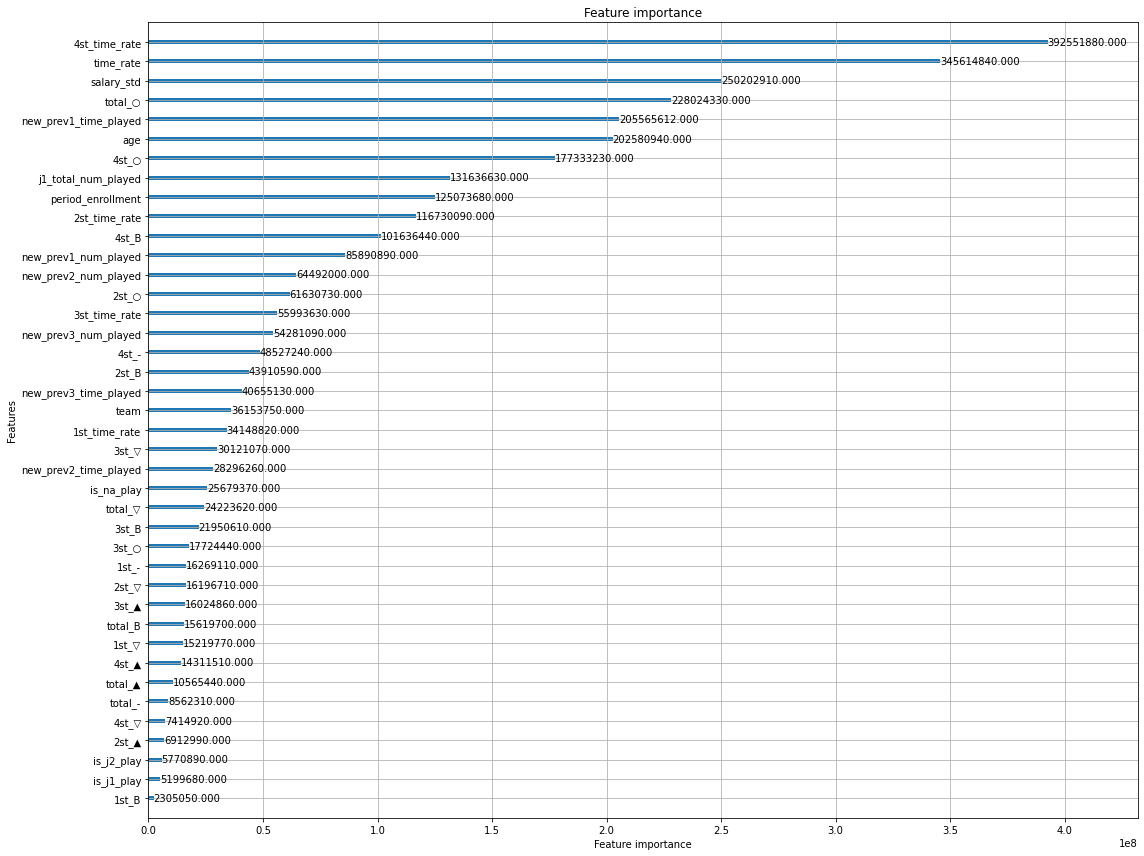

In [44]:
lgb.plot_importance(model, figsize=(16,12), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.show()